In [1]:
import warnings
import sys
sys.path.append('../src/utils')

# Core
from utils_functions import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
# Lectura de los subsets
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv').squeeze()
y_val = pd.read_csv('../data/processed/y_val.csv').squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import cross_validate

# K-Fold estratificado
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

# Pesos de las muestras
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

# Definir la métrica log-loss como métrica de evaluación
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Función de coste para evaluar el rendimiento del clasificador
def loss_function(X_train:pd.DataFrame, y_train:pd.Series, X_val:pd.DataFrame, y_val:pd.Series):
    
    # Instanciamos nuestro clasificador
    model = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=4)
    model.fit(X_train, y_train, sample_weight=sample_weight)

    # Resultados de la validación cruzada
    scores = cross_validate(model,
                            X_train,
                            y_train,
                            scoring=log_loss_scorer,
                            cv=skfold,
                            return_estimator=True,
                            return_train_score=True,
                            n_jobs=-1)
    
    # Rendimiento con el conjunto de train
    train_means = np.mean(scores['train_score'])
    train_std = np.std(scores['train_score'])

    # Rendimiento con el conjunto de validation
    val_means = np.mean(scores['test_score'])
    val_std = np.std(scores['test_score'])

    # Obtenemos el mejor estimador entrenado
    baseline_model = [estimator for idx, estimator in enumerate(scores['estimator']) if idx == np.argmax(scores['test_score'])][0]
    
    print('=== CROSS VALIDATION RESULTS ===')
    print(f'Best {type(baseline_model).__name__} with train set: {100*abs(train_means):0.2f}% mean +/- {100*train_std:0.2f}% std')
    print(f'Best {type(baseline_model).__name__} with validation set: {100*abs(val_means):0.2f}% mean +/- {100*val_std:0.2f}% std')

    print('\n=== TRAIN SET ===')
    y_pred_train = baseline_model.predict_proba(X_train)[:, 1]
    print(f'Log-Loss with train set: {100*log_loss(y_train, y_pred_train):0.2f}%')
    
    print('\n=== VALIDATION SET ===')
    y_pred_val = baseline_model.predict_proba(X_val)[:, 1]
    print(f'Log-Loss with validation set: {100*log_loss(y_val, y_pred_val):0.2f}%')
    
    return baseline_model


In [4]:
# Función de coste
model = loss_function(X_train, y_train, X_val, y_val)

=== CROSS VALIDATION RESULTS ===
Best RandomForestClassifier with train set: 41.53% mean +/- 0.08% std
Best RandomForestClassifier with validation set: 41.70% mean +/- 0.67% std

=== TRAIN SET ===
Log-Loss with train set: 41.56%

=== VALIDATION SET ===
Log-Loss with validation set: 42.13%


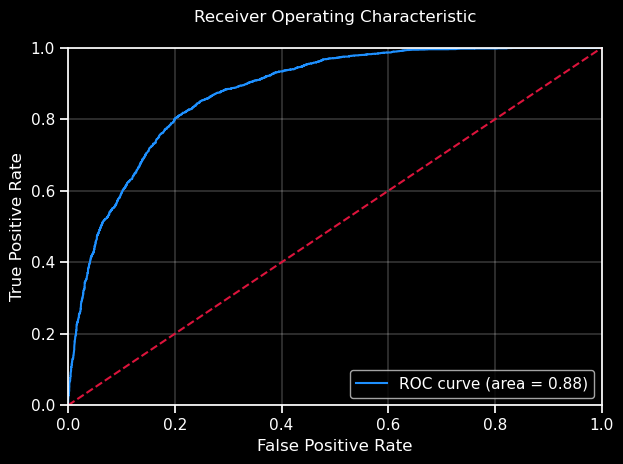

In [5]:
# Curva ROC con el modelo de línea base
roc_curve_plot(model=model, 
               X_val=X_val,
               y_val=y_val)

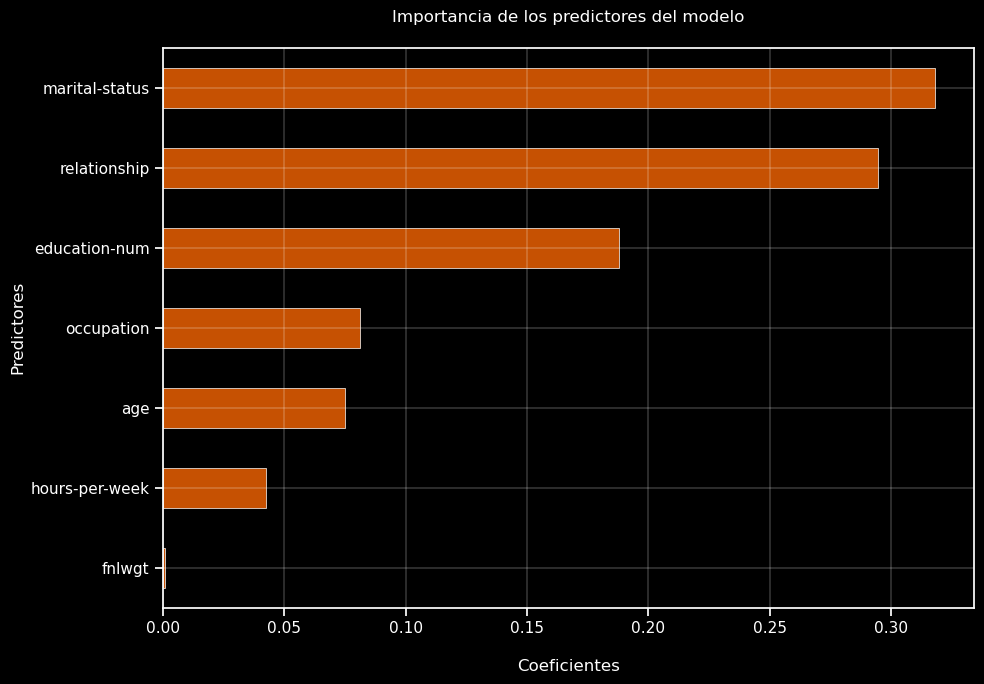

In [6]:
# Pesos de los coeficientes
coeficientes = dict(zip(model.feature_names_in_, [predictor for predictor in model.feature_importances_]))
coef_df = pd.DataFrame.from_dict(coeficientes, orient='index', columns=['coeficientes'])

# Graficar barras horizontales
coef_df.sort_values('coeficientes', ascending=True).plot.barh(figsize=(10, 7), color='xkcd:dark orange', width=0.5,
                                                              edgecolor='white', lw=0.5, legend=False)

# Agregar etiquetas y títulos
plt.title('Importancia de los predictores del modelo\n')
plt.xlabel('\nCoeficientes')
plt.ylabel('Predictores')
plt.grid(color='white', linestyle='-', linewidth=0.25)
plt.tight_layout()

In [7]:
# Reporte de clasificación para el modelo de línea base
from sklearn.metrics import classification_report

print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4455
           1       0.73      0.66      0.69      2337

    accuracy                           0.80      6792
   macro avg       0.78      0.77      0.77      6792
weighted avg       0.80      0.80      0.80      6792



In [8]:
# Exportamos características seleccionadas y el modelo de línea base
import joblib

joblib.dump(model, f'../models/{type(model).__name__}.pkl')
selected_features = coef_df[coef_df['coeficientes'] > 0.03].index
pd.Series(selected_features).to_csv('../models/selected_features.txt', index=False, header=False)

---
---